# Classification of b-quark jets in the Aleph simulated data

Python macro for selecting b-jets (sprays of particles with a b-quark in it) in Aleph Z -> qqbar MC (i.e. simulated decays of the Z0 boson decaying to a quark and an anti-quark) in various ways:
* Initially, simply with "if"-statements making requirements on certain variables. This corresponds to selecting "boxes" in the input variable space (typically called "X"). One could also try a Fisher discriminant (linear combination of input variables), which corresponds to a plane in the X-space. But as the problem is non-linear, it is likely to be sub-optimal.

* Next using Machine Learning (ML) methods. We will during the first week try both (Boosted) Decision Tree ((B)DT) based and Neural Net (NN) based methods, and see how complicated (or not) it is to get a good solution, and how much better it performs compared to the "classic" selection method.

Once you obtain a classification of b-jets vs. non-b-jets, think about how to quantify the quality of your algorithm. Also, try to compare it to the NN result of the Aleph collaboration, given by the variable "nnbjet". It is based on a neural network with 6 input variables (prob_b, spheri, pt2rel, multip, bqvjet, and ptlrel), and two hidden layers each with 10 nodes in. Can you do better?

In the end, this exercise is the simple start on moving into the territory of Machine Learning analysis.


### Data:
The input variables (X) are (where Aleph uses only the latter six):
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).
* prob_b: Probability of being a b-jet from the pointing of the tracks to the vertex.
* spheri: Sphericity of the event, i.e. how spherical it is.
* pt2rel: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* multip: Multiplicity of the jet (in a relative measure).
* bqvjet: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* ptlrel: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).

The target variable (Y) is:
* isb:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net (6 input variables, two hidden layers with 10 neurons in each, and 1 output varible) based classification variable, which you can compare to (and compete with?):
* nnbjet: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).


### Task:
Thus, the task before you is to produce functions (non-ML and then ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a _Loss Function_, which we will discuss further. In classification problems (such as this), the typical loss function to use "Cross Entropy", see https://en.wikipedia.org/wiki/Cross_entropy.

Once you have results, you're welcome to continue with a Fisher Linear Discriminant, and you may also challenge yourself by considering "v1" of the data, which is a little less "polished and ready". If you also manage this, then don't hold back in applying a real ML algorithm to the problem (you can get inspiration from "ML_MethodsDemos.ipynb" or the vast internet). A suggestion might be XGBoost or LightGBM.

* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   17th of April 2022

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

import time

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Possible other packages to consider:
cornerplot, seaplot, sklearn.decomposition(PCA)

In [2]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Read the data

...and choose input and target variables:

A few worlds on the variables and feature choices:
* 'isb' is our binary truth variables. If isb = 1 then it's a b-quark and isb = 0 if it is not.
   Because this is our truth, we must not include it as the input to our model.
* 'nnbjet' is our "competitor" e.g. a model we are supposed to benchmark against.
   Therefore 'nnbjet' shouldn't be in our input either.
* 'energy', 'cTheta', and 'phi' are kinematic variables of the jet, and not about the jet type.
   Though they might help, they were not in the original Aleph NN (nnbjet), and to compare, we omit them.

Usually one would apply further checks/regularization/standardization of data at this step, but this data has already been "prepared", so we'll move onto seperate the data into input, truth and benchmark:

In [ ]:
import pandas as pd 
from pandas import Series, DataFrame 

# Read the data in using Pandas Dataframe and print the variables:
data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_small_v2.csv', names=True))
variables = data.columns
print(variables)

# Decide on which variables to use for input (X) and what defines the label (Y):
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi')]
input_data      = data[input_variables]
truth_data      = data['isb']
benchmark_data  = data['nnbjet']
print("  Variables used for training: ", input_variables)

# Evaluate an attempt at classification:

This is made into a function, as this is called many times. It returns a "confusion matrix" and the fraction of wrong classifications.

In [3]:
def evaluate(bquark) :
    N = [[0,0], [0,0]]   # Make a list of lists (i.e. confusion matrix) for counting successes/failures.
    for i in np.arange(len(isb)):
        if (bquark[i] == 0 and isb[i] == 0) : N[0][0] += 1
        if (bquark[i] == 0 and isb[i] == 1) : N[0][1] += 1
        if (bquark[i] == 1 and isb[i] == 0) : N[1][0] += 1
        if (bquark[i] == 1 and isb[i] == 1) : N[1][1] += 1
    fracWrong = float(N[0][1]+N[1][0])/float(len(isb))
    accuracy = 1.0 - fracWrong
    return N, accuracy, fracWrong

***

# Classify B-jets using LightGBM:

This is a solution example using LightGBM (tree based).

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import lightgbm as lgb

start=time.time()

# Split data set into training and test set and feed these to LightGBM:
input_train, input_test, truth_train, truth_test, benchmark_train, benchmark_test = train_test_split(input_data, truth_data, benchmark_data, test_size=0.25, random_state=42)
lgb_train = lgb.Dataset(input_train, truth_train)
lgb_eval  = lgb.Dataset(input_test,  truth_test, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 20,
}

# Train the model:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)

# Make predictions:
y_score = gbm.predict(input_test, num_iteration=gbm.best_iteration)
y_pred  = [1 if pred > 0.5 else 0 for pred in y_score]

# Print the time usage:
end = time.time()
print(f"Time used by LightGBM: {(end-start)*1000:.1f} ms")

  Variables used for training:  Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel'],
      dtype='object')
[1]	valid_0's binary_logloss: 0.485001
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.448637
[3]	valid_0's binary_logloss: 0.420096
[4]	valid_0's binary_logloss: 0.397495
[5]	valid_0's binary_logloss: 0.3785
[6]	valid_0's binary_logloss: 0.362879
[7]	valid_0's binary_logloss: 0.349525
[8]	valid_0's binary_logloss: 0.337686
[9]	valid_0's binary_logloss: 0.327579
[10]	valid_0's binary_logloss: 0.318867
[11]	valid_0's binary_logloss: 0.311337
[12]	valid_0's binary_logloss: 0.304539
[13]	valid_0's binary_logloss: 0.298589
[14]	valid_0's binary_logloss: 0.293481
[15]	valid_0's binary_logloss: 0.288499
[16]	valid_0's binary_logloss: 0.284442
[17]	valid_0's binary_logloss: 0.280641
[18]	valid_0's binary_logloss: 0.277102
[19]	valid_0's binary_logloss: 0.274052
[20]	valid_0's binary_logloss: 0.2

Text(0, 0.5, 'True Positive Rate')

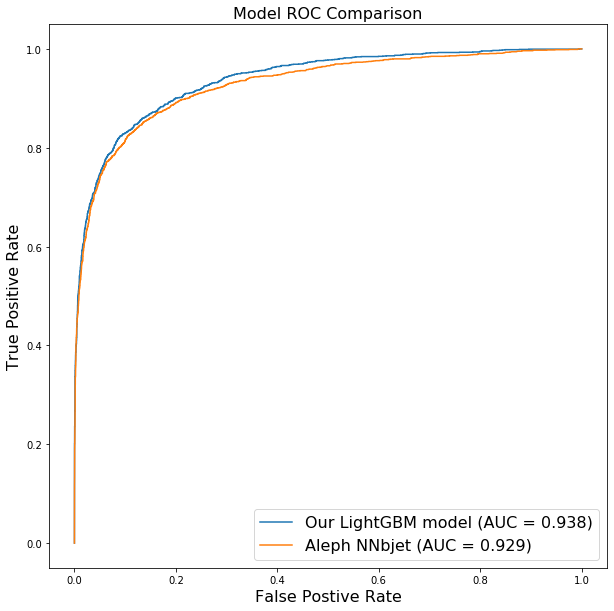

In [6]:
# Evaluate:
fpr, tpr, _ = roc_curve(truth_test, y_score)                  # False/True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_test, benchmark_test)  # False/True Positive Rate for Aleph NNbjet

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                        # This is the AUC score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)  # This is the AUC score for Aleph NNbjet

# Let's plot the ROC curves for these results:
fig = plt.figure(figsize = [10,10])
plt.title('Model ROC Comparison', size = 16)
plt.plot(fpr, tpr, label=f'Our LightGBM model (AUC = {auc_score:5.3f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'Aleph NNbjet (AUC = {auc_score_nnbjet:5.3f})')
plt.legend(fontsize=16)
plt.xlabel('False Postive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)

***

# Classify B-jets using MLPclassifier:

This is a solution example using MLPclassifier (NN based).

In [7]:
from sklearn.neural_network import MLPClassifier

start=time.time()
clf = MLPClassifier(max_iter=20000,
                    n_iter_no_change=100,           # Number of iterations without improvement before stopping
                    solver='adam',                  # Standard for minimising
                    activation='logistic',          # Standard function (but slightly slower)
                    hidden_layer_sizes=(10, 10),    # Size of network
                    learning_rate='invscaling',     # Other options are "constant" and "adaptive"
                    random_state=42)
clf.fit(input_test, truth_test)

# Make predictions (NOTE: This "spits out" two columns!):
y_score_MLP = clf.predict_proba(input_test)

# Print the time usage:
end = time.time()
print(f"Time used by MLPClassifier: {(end-start)*1000:.1f} ms")

Time used by MLPClassifier: 8878.6 ms


Text(0, 0.5, 'True Positive Rate')

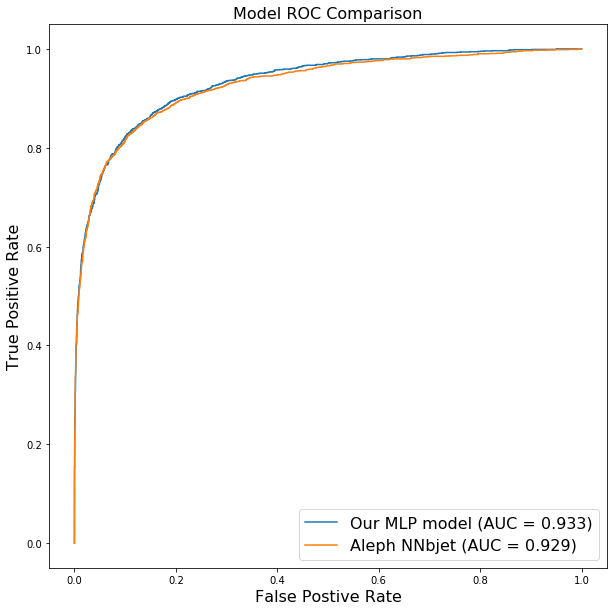

In [8]:
# Evaluate:
fpr, tpr, _ = roc_curve(truth_test, y_score_MLP[:,1])              # False/True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_test, benchmark_test)  # False/True Positive Rate for Aleph NNbjet

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                        # This is the AUC score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)  # This is the AUC score for Aleph NNbjet

# Let's plot the ROC curves for these results:
fig = plt.figure(figsize = [10,10])
plt.title('Model ROC Comparison', size = 16)
plt.plot(fpr, tpr, label=f'Our MLP model (AUC = {auc_score:5.3f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'Aleph NNbjet (AUC = {auc_score_nnbjet:5.3f})')
plt.legend(fontsize=16)
plt.xlabel('False Postive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)

***

# Classify B-jets using TensorFlow:

This is a solution example using TensorFlow (NN based).

The example is built with inspiration from
https://blog.cmgresearch.com/2020/09/06/tensorflow-binary-classification.html

The link contains additional explanitory text and short 5-minute youtube video explaining core concepts.

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_train, input_valid, truth_train, truth_valid = train_test_split(input_data, truth_data, test_size=0.25, random_state=42)

model = Sequential([
    Dense(9,activation='relu',name='input_layer'),
    Dense(24,activation='relu',name='hidden_layer1'),
    Dense(12,activation='relu',name='hidden_layer2'),
    Dense(1, activation='sigmoid', name='output')])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.losses.BinaryCrossentropy()])

print('--------- TRAINING ---------')
history = model.fit(x = np.array(input_train), y = np.array(truth_train), validation_data=(np.array(input_valid), np.array(truth_valid)), epochs = 10)  
## This trains the model on input_train by comparing to the true values in truth_train. After every epoch of training, the model is evaluated on the validation dataset, 
## namely input_valid and truth_valid.

--------- TRAINING ---------
Train on 25476 samples, validate on 8492 samples
Epoch 1/10
25476/25476 [==============================] - 2s 86us/sample - loss: 0.3195 - binary_crossentropy: 0.3193 - val_loss: 0.2700 - val_binary_crossentropy: 0.2704
Epoch 2/10
25476/25476 [==============================] - 1s 51us/sample - loss: 0.2671 - binary_crossentropy: 0.2678 - val_loss: 0.2666 - val_binary_crossentropy: 0.2670
Epoch 3/10
25476/25476 [==============================] - 1s 51us/sample - loss: 0.2662 - binary_crossentropy: 0.2660 - val_loss: 0.2628 - val_binary_crossentropy: 0.2630
Epoch 4/10
25476/25476 [==============================] - 1s 51us/sample - loss: 0.2658 - binary_crossentropy: 0.2657 - val_loss: 0.2623 - val_binary_crossentropy: 0.2626
Epoch 5/10
25476/25476 [==============================] - 1s 51us/sample - loss: 0.2652 - binary_crossentropy: 0.2659 - val_loss: 0.2626 - val_binary_crossentropy: 0.2629
Epoch 6/10
25476/25476 [==============================] - 1s 51us/s

(array([0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33]),
 <a list of 9 Text yticklabel objects>)

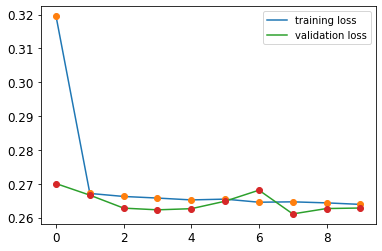

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

fig =  plt.figure()
plt.plot(training_loss,label = 'training loss')
plt.plot(training_loss,'o')
plt.plot(validation_loss, label = 'validation loss')
plt.plot(validation_loss, 'o')
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)

### Note on training curve:
As you can see, after 3rd epoch the validation loss and training loss cross each other. This is important! Do you know why? Now we have a trained model and we're ready to make predictions. Usually, one would have a test set (so in total one would have; a training set, a validation set AND a test set). But for simplicity, let's just predict on the validation sample. This is OK because the model has not trained on this set - if we asked the model to predict on examples on which it has trained, we would be cheating!

In [16]:
# Now make predictions on input_valid. Notice we're not giving it any truth values!
predictions = model.predict(input_valid)

In [19]:
fpr, tpr, _ = roc_curve(truth_valid, predictions)      # False Positive Rate and True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_valid, benchmark_data) # False Positive Rate and True Positive Rate for ALEPH model

### We can npw calculate the AUC scores of these ROC-curves
auc_score = auc(fpr,tpr)                      # this is auc score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)# this is the auc score for nnbjet


### Let's plot the results

fig = plt.figure(figsize = [10,10])
plt.title('ROC Comparison', size = 12)
plt.plot(fpr,tpr, label = 'our model')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = 'nnbjet')
plt.legend()
plt.xlabel('False Postive Rate', size = 12)
plt.ylabel('True Positive Rate', size = 12)
### This just plots a table with the AUC-scores.
row_labels=['our model',
            'nnbjet']
table_vals=[[round(auc_score,5)],
            [round(auc_score_nnbjet,5)]]
col_labels=['AUC']
the_table = plt.table(cellText=table_vals,
                  colWidths = [0.1]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')
########



ValueError: Found input variables with inconsistent numbers of samples: [8492, 33968]